## The Variational Quantum Thermalizer 

In [2]:
# Starts by importing all of the necessary dependencies

import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import random
import math
from tqdm import tqdm
import networkx as nx
import seaborn

### Introduction

The goal of this Notebook will be to help the reader understand a very interesting, recently-proposed NISQ algorithm called the **Variational Quantum Thermalizer**. This paper was one of many that has been written by the quantum team at X, the Moonshot Factory in the past couple years. Essentially, this algorithm is able to use a variational approach to reconstruct the thermal state of a given Hamiltonian at a given temperature, which is a task that is performed much more efficiently on a quantum device than a classical simulation performing the same calculations (in a very similar respect to the Variational Quantum Eigensolver). In fact, as in the original paper, we will demonstrate in this Notebook that as temperature approaches $0$, this algorithm is completely equivalent to the VQE, making the VQT a natural generalization of VQE!

### The Variational Quantum Thermalizer: The Problem Statement

Before we actually jump into simulations of this algorithm, we will attempt to understand the mathematical and physical theory that makes this theory possible. I'm going to assume that the reader already understands why variational processes like VQE and QAOA work from a physical perspective (this knowledge isn't absolutely necessary, but it is helpful, and it just so happens that a comprehensive explanation can be found in my CV QAOA Notebook!)

First off all, let us consider what we are actually trying to accomplish using this algorithm. We want to construct a **thermal state**, which is defined as:

$$\rho_\text{thermal} \ = \ \frac{e^{- H \beta / k_B}}{\text{Tr}(e^{- H \beta / k_B})}$$

Where $H$ is the Hamiltonian of our system, $\beta \ = \ 1/T$, where $T$ is the temperature of our system, and $k_B$ is Boltzman's constant (we will set this to $1$, for simplicity). Inputted into our algorithm is this Hamiltonian $H$, and our goal is to find $\rho_\text{thermal}$, or more specifically, the variational parameters that give us a state that is "very close" to $\rho_\text{thermal}$, as one does in any kind of variational quantum algorithm.

In order to do this, we will essentially pick some "simple" mixed state to start our process. We will then sample from the probability distribution of measurements of different pure states. More concretely, if we have some mixer state:

$$\rho \ = \ \displaystyle\sum_{i} p_i |x_i\rangle \langle x_i|$$

Then our probability distribution is defined as $x_i \ \sim \ p_i$, where $x_i$ corresponds to $|x_i\rangle$. We repeatedly sample values of $x_i$ corresponding to pure states in the expansion of our "simple" mixed state and pass them through a parametrized quantum circuit. We repeat this process, calculating the expectation value of the Hamiltonian for our transformed mixed state and use this value along with the Von Neumann entropy of our state to create a **free energy cost function**. We repeat the algorithm with new parameters until we minimize free energy. Once we have done this, we have arrived at the thermal state! The entire process look somewhat like this (this beautiful illustration was taken from the original paper):

<br>
<center>
<img src="images/vqt.png" style="height:250px">
    </center>
<br>

The dark grey boxes show the variational parameters that we feed into the algorithm, $\theta$ determines the probability distribution and $\phi$ determines the nature of the unitary ansatz circuit. The light grey boxes represent classical subroutines (we can sample from our probability distribution, calculate the Von Neumann entropy, $S_{\theta}$, and calculate the expectation value of our Hamiltonian classicaly). To prepare the pure state $|x\rangle$ that we samples from the distribution, we have to use the quantum subroutine $\hat{V}_x$, and then we "evolve" our basic quantum state with the variational ansatz $\hat{U}(\phi)$. Finally, we calculate loss (the black box), and cycle back to the beginning of the circuit after receiving updated variational parameters from our classical optimizer.

## Constructing the Variational Quantum Thermalizer

Now, that we understand what we are actually making, let's understand how the paper goes about constructing the VQT. We said earlier we will begin the process by creating a simple mixed state. Now, let's actually understand how we will create this simple state. Basically, the idea is to pick some $\rho_\theta$ parametrized by $\theta$ such that:

<br>
$$\rho_\theta \ = \ \frac{1}{\mathcal{Z}_\theta} e^{- K_\theta}$$
<br>

Where $\mathcal{Z}_\theta$ is simply the partition function that normalizes our density matrix, $\mathcal{Z}_{\theta} \ = \ \text{Tr}(e^{- K_\theta})$. $K_\theta$ is just some simple Hamiltonian. 

Our motivation for constructing our simple mixed state in this fashion is that it is similar in structure to that of the thermal state, which is the exponential of a Hamiltonian. In addition, recall that time evolution of a density matrix is given by multiplying it left and right by the unitary that is "doing the evolving". if you're not familiar with this, since we know that evolution of the form $|\psi\rangle \ \rightarrow \ |\psi'\rangle$ is given by $|\psi'\rangle \ = \ U|\psi\rangle$, we know that some density matrix will evolve as:

<br>
$$\rho \ = \ \displaystyle\sum_{i} p_i |\psi_i\rangle \langle \psi_i | \ \rightarrow \ \displaystyle\sum_{i} p_i |\psi_i'\rangle \langle \psi_i' | \ = \ \displaystyle\sum_{i} p_i U |\psi_i\rangle \langle \psi_i | U^{\dagger} \ = \ U \rho U^{\dagger}$$
<br>

Anyways, getting back to $K_{\theta}$, we must consider a method for selecting it. Luckily, the paper gives us a fairly obvious choice for this Hamiltonian:

<br>
$$K_{\theta} \ = \ \displaystyle\sum_{x} \theta_x |x\rangle \langle x|$$
<br>

Where each $|x\rangle$ is a computational basis state of our qubit system. This Hamiltonian is quite simple, it is diagonal in the basis that we are used to operating in, and all we have to do is take our variational parameters and slap them onto the outer products of the different basis states. We can then construct our initial mixed state as follows:

<br>
$$\rho_{\theta} \ = \ \frac{1}{\mathcal{Z}_{\theta}} e^{-K_{\theta}} \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-K_{\theta})^n}{n!} \ = \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-\sum_{k} \theta_k |k\rangle \langle k|)^n}{n!} \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{n \ = \ 0}^{\infty} \displaystyle\sum_{k} \ \frac{(-\theta_k)^n}{n!} |k\rangle \langle k| \ = \ \frac{1}{\mathcal{Z}_{\theta}} \displaystyle\sum_{k} e^{-\theta_k} |k\rangle \langle k |$$
<br>

This is great! All we have to do is sample from the probability distribution of $k \ \sim \ \frac{1}{\mathcal{Z}_\theta} e^{-\theta_k}$, prepare $|k\rangle$ which is fairly easy, since it is just a computational basis state, pass it through $\hat{U}(\phi)$, which we will discuss soon, and then repeat this process to calculate the expectation value and the cost function. 

#### The Cost Function

Let's talk more about the cost function. We will define our cost function to be the following, which we call the **relative free energy** of our system:

<br>
$$\mathcal{L}(\theta, \ \phi) \ = \ \beta \langle \hat{H} \rangle \ - \ S_\theta \ = \ \beta \ \text{Tr} (\hat{H} \ \rho_{\theta \phi}) \ - \ S_\theta \ = \ \beta \ \text{Tr}( \hat{H} \ \hat{U}(\phi) \rho_{\theta} \hat{U}(\phi)^{\dagger} ) \ - \ S_\theta$$
<br>

This is very similar to the concept of **Helmholtz free energy** from thermal physics, which is given as:

<br>
$$FE \ = \ U \ - \ TS \ = \ U \ - \ \frac{S}{\beta}$$
<br>

Where $H$ is the internal energy of the system, $T$ is the temperature, and $S$ is the entropy. Mapping this to the language of quantum states, we get:

<br>
$$F \ = \ \langle \hat{H} \rangle \ - \ \frac{S_\phi}{\beta}$$
<br>

Where internal energy is mapped to the expectation value of the energy of our quantum system, and the entropy is mapped to the Von Neumann entropy of our state. Multiplying by $\beta$, and we recover our initial loss function, $\mathcal{L}$. Now, let's convince ourselves that the thermal state of $\hat{H}$ with temperature $T \ = \ 1/\beta$ minimizes the loss function $\mathcal{L}$. Consider the **relative entropy** between our two states. This is just an extension of the concept of **Von Neumann entropy** of a quantum state, which is defined as:

<br>
$$S(\rho) \ = \ - \text{Tr} (\rho \log \rho) \ = \ - \displaystyle\sum_{n} p_n \log p_n$$
<br>

Where:

<br>
$$p_n \ = \ \langle n | \rho | n \rangle$$
<br>

Is the probability associated with measurement of the $|n\rangle$ state in the mixed state $\rho$, written as a sum of the eigenbasis formed by the eigenvectors of $\rho$. This is effectively a measure of the "density" of individual pure quantum states in our overall mixed state. With a mixed quantum state where the probabilities $p_n$ are more "spread out" over many pure states, the Von Neumann entropy is higher, whereas if our state (let's call it $\sigma$) is complete pure, then:
<br>
$$S(\sigma) \ = \ \displaystyle\sum_{n} p_n \log p_n \ = \ - p_k \log p_k \ = \ - 1 \cdot \log 1 \ = \ -1 \cdot 0 \ = \ 0$$
<br>
Because by definition of a pure state, one eigenstate has a probability of $1$, while the rest of probability $0$. The entropy is thus zero! In the event that we have a mixed state, each $p_n \ < \ 1$, it follows that $\log p_n$ is negative, making our entropy greater than $0$, thus, our entropy is minimized when we have a pure state!

Getting back on topic, we must conider the relative entropy between two states. This is just the amount of entropy that one state has, with respect to another one. For instance, if I compared the relative entropy of two copies of the same state, I would get a value of $0$, as the entropy of both states is completely the same. You can think about one of the states as our "reference point" (just as the completely pure state is our reference point in the case of normal calculations of entropy). We define this relative entropy as:

$$D(\rho_1 || \rho_2) \ = \ \text{Tr} (\rho_1 \log \rho_1) \ - \ \text{Tr}(\rho_1 \log \rho_2)$$

If we take the relative entropy of some state $\rho$ with respect to our thermal state, we get:

$$D(\rho || \rho_{\text{Thermal}}) \ = \ \text{Tr} (\rho \log \rho) \ - \ \text{Tr}(\rho \log \rho_{\text{Thermal}}) \ = \ \text{Tr} (\rho \log \rho) \ - \ \text{Tr}(\rho \log \rho_{\text{Thermal}}) \ = \ \beta \text{Tr}(\rho \hat{H}) \ - \ S(\rho) \ + \ \log \mathcal{Z}$$

Now, since relative entropy will always be greater than or equal to $0$, we know that this quantity that we have calculated will be $0$ (and thus minimized), when $\rho$ is equal to the thermal state itself. Thus, if we want to variationally learn the thermal state, all we have to do is minimize the quantity $\beta \text{Tr}(\rho \hat{H}) \ - \ S(\rho)$ (we can omit the $\log \mathcal{Z}$, as this is just an overall added constant. This is exactly the loss function that we proposed that we use initially, thus we have shown that minimization of this loss function does in fact equte to $\rho$ being in the desired thermal state! This is almost like a more general version of the variational principle: any thermal state that we prepare will have a greater "free energy" with respect to some Hamiltonian than the desired thermal state, just as the expected energy with respect some Hamiltonian of any pure state will have a greater energy than the ground state!

For fun, let's now calculate the loss function for the exact representation of the thermal state corresponding to $\hat{H}$ and $\beta$:

$$\mathcal{L}_{\text{Thermal}} \ = \ \beta \text{Tr}(\rho_{\text{Thermal}} \hat{H}) \ + \ \text{Tr} ( \rho_{\text{Thermal}} \ \log \rho_{\text{Thermal}} ) \ = \ \beta \text{Tr}\Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \hat{H} \Bigg) \ + \ \text{Tr} \Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \log \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \Bigg)$$

Where the partition function is given as:

$$\mathcal{Z}_{\beta} \ = \ \text{Tr}(e^{-\beta \hat{H}})$$

Continuing this expansion, we get:

$$\beta \text{Tr}\Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \hat{H} \Bigg) \ + \ \text{Tr} \Bigg( \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \log \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \Bigg) \ = \ \frac{1}{\mathcal{Z}_{\beta}} \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ e^{ -\beta \hat{H}} \big) \ + \ \text{Tr} \Bigg( e^{-\beta \hat{H}} \ \log \frac{e^{-\beta \hat{H}}}{\mathcal{Z}_{\beta}} \Bigg) \Bigg] \ = \ \frac{1}{\mathcal{Z}_{\beta}} \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ e^{ -\beta \hat{H}} \big) \ + \ \text{Tr} ( e^{-\beta \hat{H}} \ ( \log e^{-\beta \hat{H}} \ - \ \log \mathcal{Z}_{\beta} )) \Bigg] \ = \ \frac{1}{\mathcal{Z}_{\beta}} \ \Bigg[ \beta  \text{Tr} \big( \hat{H} \ e^{ -\beta \hat{H}} \big) \ - \ \beta \text{Tr} \big( e^{-\beta \hat{H}} \hat{H} \big) \ - \ \text{Tr} \big( e^{-\beta \hat{H}} \log \mathcal{Z}_{\beta} \big) \Bigg] \ = \ - \frac{\text{Tr} \big( e^{-\beta \hat{H}} \big) \log \mathcal{Z}_{\beta}}{\mathcal{Z}_{\beta}} \ = \ - \log \mathcal{Z}_{\beta}$$

This makes sense, since substituting it into the original expression for relative entropy gives us a value of $0$, meaning that we have preparred a state equivalent to the thermal state.

Using the Von Neumann entropy as a part of our cost function as actually super convenient, as **entropy remains invariant under unitary transformation**. This essentially means that we don't need to "compute" the entropy of our state after passing it through our ansatz circuit. Instead, we can pick an initial state with an entropy that is very easy to determine. This means that entropy is a function of only our $\theta$ parameters, and is completely independent of our choice of $\phi$! We can prove this fairly easily. Let's consider some density matrix $\rho$, with $\rho \ \rightarrow \ \rho'$ with $\rho' \ = \ U \rho U^{\dagger}$. We compute the entropy of our initial state:

$$S(\rho) \ = \ - \text{Tr} ( \rho \log \rho)$$

And then consider the entropy of our transformed state:

$$S(\rho') \ = \ - \text{Tr} (\rho' \log \rho') \ = \ - \text{Tr} ( U \rho U^{\dagger} \log (U \rho U^{\dagger})) \ = \ - \text{Tr} ( U \rho U^{\dagger} \log \rho) \ = \ - \text{Tr} ( U \rho \log \rho U^{\dagger}) \ = \ - \text{Tr} ( \rho \log \rho U^{\dagger} U) \ = \ - \text{Tr} ( \rho \log \rho) \ = \ S(\rho)$$

Therefore the entropy remains invariant under a unitary transformation, as:

$$\log (U \rho U^{\dagger}) \ = \ \log U \ + \ \log \rho \ + \ \log U^{\dagger} \ = \ \log U \ + \ \log U^{\dagger} \ + \ \log \rho \ = \ \log (U^{\dagger} U) \ + \ \log \rho \ = \ \log \rho$$

We also take advantage of the fact that $\text{Tr}(AB) \ = \ \text{Tr}(BA)$. This can also be proved fairly easily as well:

$$\text{Tr}(AB) \ = \ \displaystyle\sum_{j} AB_{jj} \ = \ \displaystyle\sum_{j, \ k} A_{jk} B_{kj} \ = \ \displaystyle\sum_{j, \ k} B_{kj} A_{jk} \ = \ \displaystyle\sum_{k} BA_{kk} \ = \ \text{Tr} (BA)$$

#### Scalability of the Algorithm

Now, we have outlined a pretty great process for learning thermal states, however, we have yet to address one large issue: **scalability**. At the moment the algorithm scales fairly poorly. Specifically, when we consider the set of parameters $\theta$ that determine our "basic" Hamiltonian, at the moment, we assign some parameter $\theta_j$ to each of the computational basis states. This means that for $n$ qubits, we require $2^n$ parameters! That design scales **incredibly** poorly. However, we can ensure that our $\theta$ parameters scale **linearly** by **parametrizing the latent space**. This esentially means that we will break our initial mixed state into multiple subcomponents, each determined by only one parameter $\theta_j$. If each component of our latent space is given by the mixed state $\rho_j$, then our total initial state will be given as:

$$\rho(\theta) \ = \ \displaystyle\bigotimes_{j} \ \rho_j (\theta_j)$$

Where, for the purposes of our simulations, we will utilize a **factorized latent space**. In addition to breaking our initial mixed state up into smalled parts, we also break apart our initial Hamiltonian, $K_\theta$ into a series of $K_{\theta_j}$ terms, with the total Hamiltonian being the sum of all these terms:

$$K_\theta \ = \ \displaystyle\sum_{j} K_{\theta_j}$$

Remembering the exponential structure of our initial mixed state:

$$\rho_\theta \ = \ \frac{1}{\mathcal{Z}_{\theta}} e^{-K_{\theta}} \ = \ \frac{1}{\mathcal{Z}_{\theta}} e^{-{\sum_j K_{\theta_j}}} \ \Rightarrow \ \bigotimes_{j} \ \frac{1}{\mathcal{Z}_{\theta}} e^{-{K_{\theta_j}}}$$

It becomes a tensor product of the individual subspaces if we define our initial mixed states $\rho_j$ only over the smaller Hilbert space in which each "operates" (for example, the basis $|0\rangle$ and $|1\rangle$). We can now choose a basic form for our parametrized "sub-Hamiltonians":

$$K_{\theta_j} \ = \ \displaystyle\sum_{k} \ \theta_{jk} |k\rangle \langle k|_{j}$$

After we do this, we may re-write our initial state:

$$\rho_{\theta_j} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} e^{-K_{\theta_j}} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-K_{\theta_j})^n}{n!} \ = \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{n \ = \ 0}^{\infty} \ \frac{(-\sum_{k} \theta_{jk} |k\rangle \langle k|_j)^n}{n!} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{n \ = \ 0}^{\infty} \displaystyle\sum_{k} \ \frac{(-\theta_{jk})^n}{n!} |k\rangle \langle k|_j \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \displaystyle\sum_{k} e^{-\theta_{jk}} |k\rangle \langle k |_j$$

So, if we are operating in a Hilbert space with dimension $2$ (we will likely be performing this experiment with qubits, thus this will be the case, however, thr algorithm can be generalized to $d$-level qudits), in the basis of $|k\rangle_j$, we have:

$$\rho_{\theta_j} \ = \ \frac{1}{\mathcal{Z}_{\theta_j}} \begin{pmatrix} e^{-\theta_{j0}} & 0 \\ 0 & e^{-\theta_{j1}} \end{pmatrix} \ = \ \begin{pmatrix} p_j(\theta_{j0}) & 0 \\ 0 & p_j(\theta_{j1}) \end{pmatrix}$$

This form suggests to us that we may be able to make the algorithm even more scalable. Right now, we require $2n$ parameters in the set $\theta$, however, due to the normalization condition, it must be true that:

$$p_j(\theta_{j0}) \ + \ p_j(\theta_{j1}) \ = \ 1$$

We wish to eliminate the parameter $\theta_{j1}$ from our initial states, leaving only one parameter for each of the mixed states. Without loss of generality:

$$p_j(\theta_{j1}) \ = \ 1 \ - \ e^{-\theta_{j0}}$$

And making it so that each $\rho_j$ is given as:

$$\rho_{\theta_j} \ = \ \begin{pmatrix} p_j(\theta_{j}) & 0 \\ 0 & 1 \ - \ p_j(\theta_{j}) \end{pmatrix} \ = \ \begin{pmatrix} e^{-\theta_{j}} & 0 \\ 0 & 1 \ - \ e^{-\theta_{j}} \end{pmatrix}$$

Where we have renamed $\theta_{j0}$ to $\theta_{j}$, as we are left with only one parameter. This is a huge improvement, we have reduced thee number of $\theta$ parameters from $2^n$ to $n$!

To conclude our discussion of the theory (so we can actually move onto the experiments), we will also make note that the construction of our unitary $\hat{U}(\phi)$ will vary from problem to problem, so we will discuss this in more depth for each simulation that we run.

#### VQT At Zero Temperature: The Variational Quantum Eigensolver

There is one more thing that we have to discuss before we start taking a look at some real simulations. This, in my humble opinion, is one of the coolest things about this entire quantum algorithm: as temperature approaches $0$, the VQT converges towards the well-known VQE! We can prove this more easily than you would think, if we investigate the cost function:

$$\mathcal{L}(\theta, \ \phi) \ = \ \beta \langle \hat{H} \rangle \ - \ S_\theta$$

We then divide by $\beta$ (keep in mind that for a fixed value of $\beta$, it just acts as some overall scaling parameter: the minimum of the function remains unchanged). We get:

$$\frac{1}{\beta} \ \mathcal{L}(\theta, \ \phi) \ = \ \langle \hat{H} \rangle \ - \ \frac{1}{\beta} \ S_\theta \ = \ \langle H \rangle \ - \ T S_\theta$$

So in the limit of $0$ temperature, since we know that the Von Neumann entropy is bounded above and below, the entropy/temperature term will approach $0$, and we will get:

$$\frac{1}{\beta} \ \mathcal{L}(\theta, \ \phi) \ \rightarrow \ \langle H \rangle \ \ \ \ \text{for} \ \ \ T \ \rightarrow \ 0$$

Which is exactly the Variational Quantum Eigensolver: preparring some arbitrary quantum state and then minimizing the exepcted value of the Hamiltonian to find the ground state! This then tells us that the VQT is really just a generalization of the VQE, for mixed states at temperatures above absolute $0$!

### The 3-Qubit Ising Model on a Line

#### Numerical Calculation of Target State

We begin by calculating the target state numerically, so that it can be compared to the state our circuit prepares. We begin by defining a few fixed values that we will use throughout this example:

In [217]:
# Defines all necessary variables

beta = 0.5 #Note that B = 1/T
qubit = 3
qubits = range(qubit)
depth = 2

# Defines the device on which the simulation is run

dev = qml.device("default.qubit", wires=len(qubits))

The model that we are investigating lives on a linear graph, which we will construct using `networkx` for the purposes of eventually constructing our Hamiltonian:

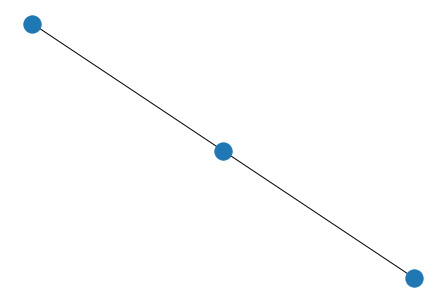

In [218]:
# Creates the graph of interactions for the Heisenberg grid, then draws it

interaction_graph = nx.Graph()
interaction_graph.add_nodes_from(range(0, qubit))
interaction_graph.add_edges_from([(0, 1), (1, 2)])

nx.draw(interaction_graph)

Next, we can implemented a method that actually allows us to calculate the matrix form of our Hamiltonian (in the $Z$-basis). The Ising model Hamiltonian can be written as:

<br>
$$\hat{H} \ = \ \displaystyle\sum_{j} X_{j} X_{j + 1} \ + \ \displaystyle\sum_{i} Z_{i}$$
<br>

We can write this as a function, that returns the $n$-qubit matrix form of the Ising model Hamiltonian:

In [219]:
# Builds the Ising model Hamiltonian, for a given number of qubits and an interaction graph

def create_hamiltonian_matrix(n, graph):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))

    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)


    return matrix

# Constructs the Hamiltonian we will deal with in this simulation

ham_matrix = create_hamiltonian_matrix(qubit, interaction_graph)
print(ham_matrix)

[[ 3.  0.  0.  1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0. -1.  1.  0.]
 [ 1.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -3.]]


With all of this done, all that is left to do is construct the target thermal state. We know that the thermal state is of the form:

<br>
$$\rho_{\text{thermal}} \ = \ \frac{e^{-\beta \hat{H}}}{\mathcal{Z}}$$
<br>

Thus, we can calculate it by taking the matrix exponential of the Hamiltonian. The partition function can be found by simply taking the trace of the numerator (as it simply acts as a normalization factor). In addition to finding the thermal state, let's go one step further and also calculate the value of the cost function associated with this target state. Thus, we will have:

In [220]:
# Creates the target density matrix

def create_target(qubit, beta, ham, graph):
    
    # Calculates the matrix form of the density matrix, by taking the exponential of the Hamiltonian
    
    h = ham(qubit, graph)
    y = -1*float(beta)*h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1/norm)*new_matrix

    # Calculates the entropy, the expectation value, and the final cost

    entropy = -1*np.trace(np.matmul(final_target, scipy.linalg.logm(final_target)))
    ev = np.trace(np.matmul(final_target, h))
    real_cost = beta*np.trace(np.matmul(final_target, h)) - entropy

    # Prints the calculated values

    print("Expectation Value: "+str(ev))
    print("Entropy: "+str(entropy))
    print("Final Cost: "+str(real_cost))
    
    return final_target

Finally, we can calculate the thermal state corresponding to our Hamiltonian and inverse temperature, and visualize it using the `seaborn` data visualization library:

Expectation Value: -2.0792714902324483
Entropy: 1.6078317133217728
Final Cost: -2.6474674584379967


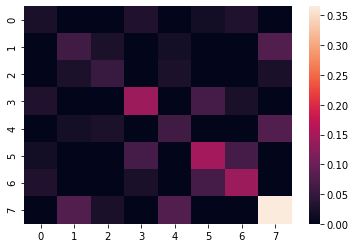

In [221]:
# Plots the final density matrix

final_density_matrix = create_target(qubit, beta, create_hamiltonian_matrix, interaction_graph)
seaborn.heatmap(abs(final_density_matrix))

#### Variational Quantum Thermalization of the Heisenberg Model

Now that we know exactly what our thermal state should look like, let's attempt to construct it with the VQT. Let's begin by constructing the classical probability distribution, which gives us the probabilities corresponding to each basis state in the expansion of our density matrix. As we discussed earlier in this Notebook, we will be using the factorized latent space model, with the probability associated with the $j$-th one-qubit system being:

<br>
$$p(\theta_{j}) \ = \ \frac{e^{\theta_j}}{e^{\theta_j} \ + \ 1}$$
<br>

which we can implement as:

In [222]:
# Creates the probability distribution according to the theta parameters

def sigmoid(x):

    return (math.exp(x) / (math.exp(x) + 1))

From this, we can construct a function that actually constructs the probability distribution itself, which will be a function that returns a list of pairs of probabilities that correspond to each one-qubit system in the factorized latent space:

In [223]:
# Creates the probability distributions for each of the one-qubit systems

def prob_dist(params):
    
    dist = []
    for i in params:
        dist.append([sigmoid(i), 1-sigmoid(i)])
    
    return dist

Now, with this done, we have to define the quantum parts of our circuit. Befor any qubit register is passed through the variational circuit, we must prepare it in a given basis state. Thus, we can write a function that takes a list of bits, and returns a quantum circuit that prepares the corresponding basis state (in the computational basis): 

In [224]:
#Creates the initialization unitary for each of the computational basis states

def create_v_gate(prep_state):

    for i in range(0, len(prep_state)):
        if (prep_state[i].val == 1):
            qml.PauliX(wires=i)

All that is left to do before we construct the cost function is to construct the parametrized circuit, through which we pass our initial states. We will use a multi-layered ansatz, where each layer is composed of $RX$, $RZ$, and. $RY$ gates on each qubit, followed by exponentiated $CNOT$ gates placed between qubits that share an edge in the interaction graph. Our general single-qubit rotations can be implemented as:

In [225]:
# Creates the single rotational ansatz

def single_rotation(phi_params, q):

    qml.RZ(phi_params[0], wires=q)
    qml.RY(phi_params[1], wires=q)
    qml.RX(phi_params[2], wires=q)

Putting this together with the $CNOT$ gates, we have a general ansatz of the form:

In [226]:
# Creates the ansatz circuit

def ansatz_circuit(params, qubits, layers, graph, param_number):
    
    param_number = int(param_number.val)
    number = param_number*qubit + len(graph.edges)

    # Partitions the parameters into param lists
    partition = []
    for i in range(0, int((len(params)/number))):
        partition.append(params[number*i:number*(i+1)])
    
    qubits = range(qubit)
    
    for j in range(0, depth):
        
        sq = partition[j][0:(number-len(graph.edges))]
        
        for i in qubits:
            
            single_rotation(sq[i*param_number:(i+1)*param_number], i) 

        for count, i in enumerate(graph.edges):
            p = partition[j][(number-len(graph.edges)):number]
            qml.CRX(p[count], wires=[i[0], i[1]])

There are a lot of variables floating around in this function. The `param_number` variable simply tells us how many unique parameters we assign to each application of the single-qubit rotation layer. We multiply this by the number of qubits, to get the total number of single-rotation parameters, and then add the number of edges in the interaction graph, which will also be the number of unique parameters needed for the $CNOT$ gates. With all of these components, we can define a function that acts as our quantum circuit, and pass it into a QNode:

In [227]:
# Creates the quantum circuit

def quantum_circuit(params, qubits, sample, param_number):

    # Prepares the initial basis state corresponding to the sample

    create_v_gate(sample)

    # Prepares the variational ansatz for the circuit

    ansatz_circuit(params, qubits, depth, interaction_graph, param_number)
    
    # Calculates the expectation value of the Hamiltonian, with respect to the preparred states
     
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(qubit)))

qnode = qml.QNode(quantum_circuit, dev)

# Tests and draws the QNode

results = qnode([1 for i in range(0, 12*depth)], qubits, [1, 0, 1, 0], 3)
print(qnode.draw())

 0: ──X──────RZ(1)──RY(1)──RX(1)──╭C───────RZ(1)──RY(1)──RX(1)─────────╭C──────────────╭┤ ⟨H0⟩ 
 1: ──RZ(1)──RY(1)──RX(1)─────────╰RX(1)──╭C──────RZ(1)──RY(1)──RX(1)──╰RX(1)──╭C──────├┤ ⟨H0⟩ 
 2: ──X──────RZ(1)──RY(1)──RX(1)──────────╰RX(1)──RZ(1)──RY(1)──RX(1)──────────╰RX(1)──╰┤ ⟨H0⟩ 
H0 =
[[ 3.  0.  0.  1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0. -1.  1.  0.]
 [ 1.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -3.]]



There is one more thing we must do before implementing the cost function: writing a method that allows us to calculate the entropy of a state. Actually implementing a function that calculates the Von Neumann entropy is not too involved. We will take a probability distribution as our argument, which corresponds to the diagonal elements of the density matrix in its eigenbasis (which are just the eigenvalues, or physically, the probability of measuring a given eigenstate of the density matrix). As you will soon see, we will be dealing with many $1$-qubit systems, rather than one large qubit system. Thus, we wish to calculate the entropy of each of the $1$-qubit systems individually. The `distribution` variable is an array of pairs $(p_0, \ p_1)$, which are the probabilities corresponding to $|0\rangle$ and $|1\rangle$, which are the eigenstates as our initial density matrices will each be diagonal in the $Z$-basis. We can take each of these pairs, calculate the sum given above, and return a list of entropies, for each subsystem:

In [228]:
#Calculate the Von Neumann entropy of the initial density matrices

def calculate_entropy(distribution):

    total_entropy = []
    for i in distribution:
        total_entropy.append(-1*i[0]*np.log(i[0]) + -1*i[1]*np.log(i[1]))
    
    #Returns an array of the entropy values of the different initial density matrices

    return total_entropy

Finally, we define the cost function. More specifically, this is an `exact` version of the VQT cost function. Instead of sampling from our classical probability distribution, we simply calculate the probability corresponding to every basis state, and thus calculate the energy expectation exactly for each iteration. this is not how the VQT would work in the real world, for large systems where the number of basis states (and thus the size of the probability distribution) scales exponentially, but for small toy-models such as this, the exact form runs faster:

In [229]:
def exact_cost(params):
    
    global iterations
    
    # Separates the list of parameters
     
    dist_params = params[0:qubit]
    params = params[qubit:]
    
    # Creates the probability distribution
    
    distribution = prob_dist(dist_params)
    
    # Generates a list of all computational basis states, of our qubit system
    
    s = [[int(i) for i in list(bin(k)[2:].zfill(qubit))] for k in range(0, 2**qubit)]
    
    # Passes each basis state through the variational circuit and multiplis the calculated energy EV with the associated probability from the distribution
    
    final_cost = 0
    for i in s:
        result = qnode(params, qubits, i, 3)
        for j in range(0, len(i)):
            result = result*distribution[j][i[j]]
        final_cost += result
     
    # Calculates the entropy and the final cost function
    
    entropy = calculate_entropy(distribution)
    final_final_cost = beta*final_cost - sum(entropy)
    
    if (iterations%50 == 0):
        print("Cost at Step "+str(iterations)+": "+str(final_final_cost))
    
    iterations += 1
    
    return final_final_cost

Finally, we optimize the cost function:

In [230]:
# Creates the optimizer

iterations = 0

params = [random.randint(-100, 100)/100 for i in range(0, (12*depth)+3)]
out = minimize(exact_cost, x0=params, method="COBYLA", options={'maxiter':750})
params = out['x']
print(out)

Cost at Step 0: -2.1074085748583906
Cost at Step 50: -2.290476911551978
Cost at Step 100: -2.463162796083161
Cost at Step 150: -2.484429759899141
Cost at Step 200: -2.4950124353655396
Cost at Step 250: -2.5021674540839447
Cost at Step 300: -2.509340412084976
Cost at Step 350: -2.514700397896745
Cost at Step 400: -2.521175437350474
Cost at Step 450: -2.526962995339277
Cost at Step 500: -2.5342117156323685
Cost at Step 550: -2.5406848965838456
Cost at Step 600: -2.5465575615058103
Cost at Step 650: -2.5515082595595837
Cost at Step 700: -2.556629576145811
     fun: -2.561781112766892
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 750
  status: 2
 success: False
       x: array([-0.96156611,  1.17498178, -1.29965099,  0.28689681, -0.16625431,
       -1.43122622,  1.15704363, -0.12913136,  1.27762797, -0.14209757,
        0.133123  ,  0.14368184,  0.98721803,  0.96242412,  0.07335088,
        1.27541239,  1.28309057, -0.45467766, -1.25709913,  

With our optimal parameters, we now wish to prepare the state to which they correspond, to see "how close" our prepared state is to the target state. This can be done by simply taking the optimal parameters, and passing each possible basis state through the variational circuit. Each corresponding probability is multiplied by the outer product of the resulting state with itself. Once we add these all together, we are left with the density matrix corresponding to the optimal parameters.

In [231]:
def prepare_state(params, device):

    # Initializes the density matrix

    final_density_matrix_2 = np.zeros((2**qubit, 2**qubit))

    # Prepares the optimal parameters, creates the distribution and the bitstrings

    dist_params = params[0:qubit]
    unitary_params = params[qubit:]

    distribution = prob_dist(dist_params)

    s = [[int(i) for i in list(bin(k)[2:].zfill(qubit))] for k in range(0, 2**qubit)]

    # Runs the circuit in the case of the optimal parameters, for each bitstring, and adds the result to the final density matrix

    for i in s:
        qnode(unitary_params, qubits, i, 3)
        state = device.state
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]])*state
        final_density_matrix_2 = np.add(final_density_matrix_2, np.outer(state, np.conj(state)))
    
    return final_density_matrix_2

final_density_matrix_2 = prepare_state(params, dev)

Now, we need to asess how "close together" the prepared and target state are. The trace distance of two density matrices is a valid metric (a "distance function" with certain properties) on the space on density matrices defined by:

<br>
$$T(\rho, \ \sigma) \ = \ \frac{1}{2} \text{Tr} \sqrt{(\rho \ - \ \sigma)^{\dagger} (\rho \ - \ \sigma)}$$
<br>

We can implement this as a function, and compute the trace distance between the target and prepared states:

In [232]:
# Finds the trace distance between two density matrices

def trace_distance(one, two):
    
    return 0.5*np.trace(np.absolute(np.add(one, -1*two)))

print("Final Fidelity: "+str(trace_distance(final_density_matrix_2, final_density_matrix)))

Final Fidelity: 0.05399297058790893


This is pretty good! A trace distance close to $0$ means that the states are "close together", meaning that we prepared a good approximation of the thermal state. If you prefer a vision representation, we can plot the prepared state as a heatmap:

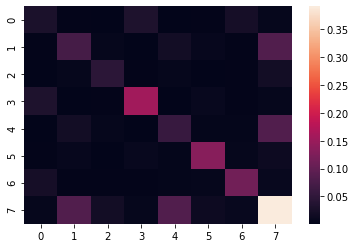

In [233]:
seaborn.heatmap(abs(final_density_matrix_2))

Then, we can compare it to the target:

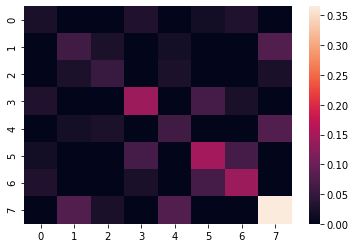

In [208]:
seaborn.heatmap(abs(final_density_matrix))

As you can see, the two images are not completely the same, but there is definitely some resemblance between them!

### The 4-Qubit Heisenberg Model on a Square

Let's look at one more example of the VQT in action, this time, for a slightly more complicated model.

#### Numerical Calculation of Target State

As we did in the above example, we define our fixed values:

In [234]:
# Defines all necessary variables

beta = 1 #Note that B = 1/T
qubit = 4
qubits = range(qubit)
depth = 2

# Defines the device on which the simulation is run

dev2 = qml.device("default.qubit", wires=len(qubits))

This model lives on a square-shaped graph:

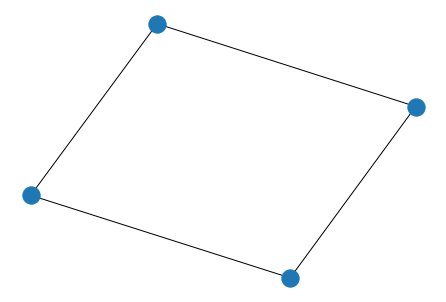

In [235]:
# Creates the graph of interactions for the Heisenberg grid, then draws it

interaction_graph = nx.Graph()
interaction_graph.add_nodes_from(range(0, qubit))
interaction_graph.add_edges_from([(0, 1), (2, 3), (0, 2), (1, 3)])

nx.draw(interaction_graph)

Recall that the two-dimensional Heiseberg model Hamiltonian can be written as:

<br>
$$\hat{H} \ = \ \displaystyle\sum_{(i, j) \in E} X_i X_{j} \ + \ Z_i Z_{j} \ + \ Y_i Y_{j}$$
<br>

With this knowledge, we have:

In [236]:
# Creates the target Hamiltonian matrix

def create_hamiltonian_matrix(n, graph):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])
    
    matrix = np.zeros((2**n, 2**n))
    
    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(pauli_x,  m)
            else:
                m = np.kron(identity, m)
        matrix = np.add(matrix, m)
     
    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(m, pauli_y)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    return matrix

ham_matrix = create_hamiltonian_matrix(qubit, interaction_graph)
print(ham_matrix)

[[ 4.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j
   2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j
   2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  2.+0.j -4.+0.j  0.+0.j  0.+0.j
   0.+0.j  2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.

So this is the $Z$-basis matrix form of the Hamiltonian. We then calculate the thermal state at the inverse temperature defined above:

Expectation Value: (-7.7740126937547025+0j)
Entropy: (0.2817302684780885+9.410928517774377e-17j)
Final Cost: (-8.055742962232792-9.410928517774377e-17j)


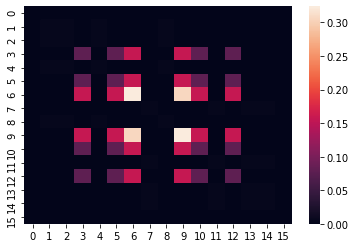

In [237]:
# Plots the final density matrix

final_density_matrix = create_target(qubit, beta, create_hamiltonian_matrix, interaction_graph)
seaborn.heatmap(abs(final_density_matrix))

We will use the same form of the latent space, ansatz, and cost function as above, thus only minor modifications need to be made. We must re-define our qnode, since we are now using a device with $4$ qubits rather than $3$:

In [238]:
# QNode

qnode = qml.QNode(quantum_circuit, dev2)

We then run our optimizer:

In [185]:
# Creates the optimizer

iterations = 0

params = [random.randint(-100, 100)/100 for i in range(0, (16*depth)+4)]
out = minimize(exact_cost, x0=params, method="COBYLA", options={'maxiter':750})
params = out['x']
print(out)

Cost at Step 0: -2.5251635138997366
Cost at Step 50: -4.227000827296257
Cost at Step 100: -4.699842353725709
Cost at Step 150: -5.5127170812681445
Cost at Step 200: -6.121743460175592
Cost at Step 250: -6.298428589474547
Cost at Step 300: -6.478125065035863
Cost at Step 350: -6.61972599353439
Cost at Step 400: -6.78274466684268
Cost at Step 450: -6.898267435244163
Cost at Step 500: -7.005018831844215
Cost at Step 550: -7.054391163148315
Cost at Step 600: -7.16695535682297
Cost at Step 650: -7.22440101437725
Cost at Step 700: -7.271934821214829
     fun: -7.331954760513113
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 750
  status: 2
 success: False
       x: array([ 3.07876493, -3.4905453 , -3.34190301,  3.74346123,  0.16354655,
        1.60454049, -0.99800892,  0.57027738,  0.99946704, -1.11951889,
       -0.61437673, -1.57001476, -0.14081913,  2.2070329 ,  0.40092247,
       -0.26548317,  0.01480874,  0.2663962 ,  0.13454219, -1.4108988

With our optimal parameters, we can post-process our data. We start by calculating the matrix form of the density matrix we prepared:

In [242]:
# Prepares the density matrix

final_density_matrix_2 = prepare_state(params, dev2)

We then calculate the trace distance:

In [240]:
# Calculates the trace distance

print("Final Fidelity: "+str(trace_distance(final_density_matrix_2, final_density_matrix)))

Final Fidelity: 0.0978468923259927


This is pretty good, but it could be better (most likely with a deeper ansatz and a more sophisticated optimizer, but to keep execution time relatively sohrt, we will not go down those avenues in this Notebook). To end off, let's visualize our two density matrices:

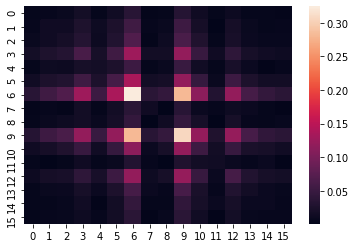

In [187]:
seaborn.heatmap(abs(final_density_matrix_2))

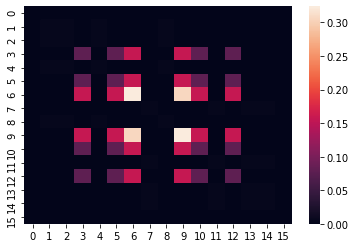

In [241]:
seaborn.heatmap(abs(final_density_matrix))